# Taller de clasificación - Noticias


- Jesús Alberto Florez Lizarazo
- Lucero Zarate Herrera
- Víctor Echavarría

### En este notebook se presenta una evaluación de modelos para el problema de clasificar un aproximado de 2000 noticias de la BBC que estan en idioma ingles con una categorización en 5 clases: busisnes, politics, entertaiment, sport, tech.

### 1. Instalaciones

In [10]:
!pip install nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 2. Librerias

In [11]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import re

from pandas import DataFrame
import joblib
import time

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [12]:
# Cargar datos con colab
# =============================================================================
from google.colab import drive
import os
drive.mount('/gdrive')

os.chdir("/gdrive/MyDrive/ML")
!ls

Mounted at /gdrive
18_AnalisisTextoClasificacionNoticias.ipynb  bbc-text.csv  model01.model  model02.model


### 3. Carga de datos

Se carga la base de datos de noticias en ingles de bbc que tiene una categorización establecida.

In [13]:
df = pd.read_csv("/gdrive/MyDrive/ML/bbc-text.csv")
df.head(8)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...


### 4. Preparación de datos

- Se validan datos nulos y duplicados.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [15]:
#Checking for duplicates
df.loc[df.duplicated()]

,category,text
85,politics,hague given up his pm ambition former conser...
301,politics,fox attacks blair s tory lies tony blair lie...
496,tech,microsoft gets the blogging bug software giant...
543,business,economy strong in election year uk businesse...
582,entertainment,ray dvd beats box office takings oscar-nominat...
...,...,...
2206,politics,kennedy questions trust of blair lib dem leade...
2207,tech,california sets fines for spyware the makers o...
2213,tech,progress on new internet domains by early 2005...
2215,tech,junk e-mails on relentless rise spam traffic i...


In [16]:
df = df.drop_duplicates()
df.dropna(inplace=True)
df.shape

(2126, 2)

### 5.  Descripción de categorías a clasificar

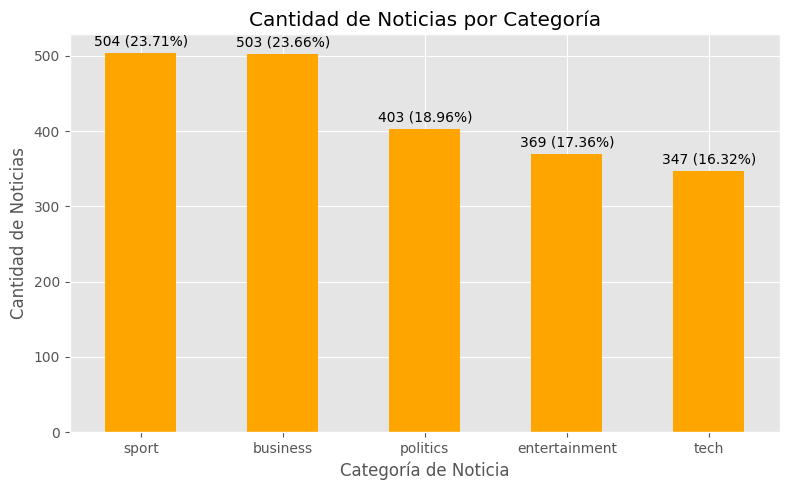

In [17]:
fig = plt.figure(figsize=(8,5))
# Agrupar los datos por categoría y contar la cantidad de noticias en cada una
category_counts = df.groupby('category').text.count().sort_values(ascending=False)

# Graficar las barras ordenadas
category_counts.plot(kind='bar', color='orange')

# Añadir título y etiquetas
plt.title('Cantidad de Noticias por Categoría')
plt.ylabel('Cantidad de Noticias')
plt.xlabel('Categoría de Noticia')

# Añadir porcentajes en las barras
total_news = df.shape[0]
for i, count in enumerate(category_counts):
    plt.text(i, count + 10, f'{count} ({(count / total_news) * 100:.2f}%)', ha='center', fontsize=10)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 5.  Preprocesamiento de texto y creación de bolsa de palabras
- Para el procesamiento de datos se realiza una normalización de las noticias.
- Se lleva cada una de las palabras a su raiz.


**Tf-idf** (del inglés Term frequency – Inverse document frequency), frecuencia de término – frecuencia inversa de documento (o sea, la frecuencia de ocurrencia del término en la colección de documentos), es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección.

In [18]:
# Revisar eliminación de una lista adicional de palabras.
english_stopwords = stopwords.words('english') + list(punctuation)

#función stemmer para llevar palabras a su raiz.
snow_stemmer = SnowballStemmer(language='english')

# Función para normalizar el texto: tokenización, eliminación de signos de puntuación y stopwords,
# y conservación solo de palabras de más de 3 caracteres
def normalize(text):
    doc = nlp(text)  # Tokenizar el texto utilizando Spacy
    words = [t.orth_ for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if len(t) > 3 and t.isalpha()]
    return lexical_tokens  # Retornar lista de palabras filtradas

inicio = time.time()
# Inicializar un nuevo DataFrame para almacenar los textos normalizados y llevados a su raíz
df_stem = pd.DataFrame()
for i in df.index:
    text_norm = normalize(df.text[i])
    # Llevar cada palabra del texto a su raíz utilizando el stemmer de Snowball
    stems = [snow_stemmer.stem(token) for token in text_norm]
    text_stem = " ".join(stems)   # Unir las palabras raíz en un solo texto
    # Almacenar el texto raíz y la categoría en el nuevo DataFrame
    df_stem.loc[i, 'text'] = text_stem
    df_stem.loc[i, 'category'] = df.category[i]
fin = time.time()

print(f'El tiempo necesario para llevar sus palabras a su raiz es: {(fin-inicio)/60} min' )

El tiempo necesario para llevar sus palabras a su raiz es: 3.1733020544052124 min


In [19]:
# Comparación texto inicial versus llevado a su raiz
print(df.text[3], '\n', df_stem.text[3])

yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round.  the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading  who beat slough in the second round. conference side exeter city  who knocked out doncaster on saturday  will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scunthorpe. the only other non-league side in the draw are hinckley united  who held brentford to a goalless draw on sunday. they will meet league one leaders luton if they win their replay against martin allen s team at griffin park.  a number of premiership teams face difficult away games against championship sides on the weekend of 8/9 january. third-placed everton visit plymouth  liverpool travel to burnley  crystal palace go to sunderland  fulham face carling cup semi-finalists watford  bolton mee

### **Creación de bolsa de palabras**
- Para la creación de bolsa de palabras se realiza el proceso para dos datasets, uno de ellos llevando las palabras a su raiz y el otro con todas las palabras.

In [20]:
#Creacion de bolsa de palabras llevando las palabras a su raiz.
# Se puede vectorizar con otros métodos
vectorizer_stem = TfidfVectorizer(sublinear_tf=True       #transformación logarítmica suavizada en frcuencia de término.
                                                     # ayuda a reducir el impacto de las frecuencias de término altas
                                                     # y mejora el rendiemiento.
                             , min_df= 10            # los terminos deben aparecer en al menos 10 documentos
                             , max_df= 100           # los terminos deberian aparecer un maximo de 100 veces
                             , encoding='utf-8'    # Se puede ver utf-8 como diccionario tambien esta latin-1
                             , ngram_range=(1, 2)
                             , stop_words=english_stopwords
                       )
features_stem = vectorizer_stem.fit_transform(df_stem.text)
labels_stem = df_stem['category']
features_stem.shape

(2126, 4163)

In [21]:
terms_aju = vectorizer_stem.get_feature_names_out()
doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(features_stem)]
dv = pd.DataFrame(data=features_stem.toarray(), index=doc_names, columns=terms_aju)
dv.head()

,abandon,abid,abil,abolish,abroad,absenc,absent,absolut,absorb,abus,...,youth,yuan,yugansk,yuganskneftega,yuko,yuko claim,zealand,zero,zone,zurich
0,0.0,0.088516,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.082898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Creacion de bolsa de palabras llevando sin llevar las palabras a su raiz.
# Se puede vectorizar con otros métodos
vectorizer_norm = TfidfVectorizer(sublinear_tf=True       #transformación logarítmica suavizada en frcuencia de término.
                                                     # ayuda a reducir el impacto de las frecuencias de término altas
                                                     # y mejora el rendiemiento.
                             , min_df= 10            # los terminos deben aparecer en al menos 10 documentos
                             , max_df= 100           # los terminos deberian aparecer un maximo de 100 veces
                             , encoding='utf-8'    # Se puede ver utf-8 como diccionario tambien esta latin-1
                             , ngram_range=(1, 2)
                             , stop_words=english_stopwords
                       )
features = vectorizer_norm.fit_transform(df.text)
terms_ini = vectorizer_norm.get_feature_names_out()

# Procesamiento de datos con los textos sin llevar a su raiz
# Identificación de números en las cadenas de
# Tu array con cadenas de texto
array_cadenas = terms_ini

# Expresión regular para encontrar números enteros y decimales
patron_numeros = re.compile(r'\d+(\.\d+)?')

# Lista para almacenar los números encontrados
numeros_encontrados = []

# Iterar sobre el array y encontrar los números usando la expresión regular
for cadena in array_cadenas:
    match = patron_numeros.search(cadena)
    if match:
        numeros_encontrados.append(match.group())
print("Numeros encontrados: ", numeros_encontrados)

#nums = ['00', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '000', '01', '03', '04', '05', '06', '07', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '10', '100', '100', '100', '100', '100', '100', '100', '100', '101', '102', '103', '104', '105', '10', '10', '10', '11', '11', '11', '11', '11', '11', '11', '110', '110', '111', '115', '11', '11', '12', '12', '12', '12', '12', '12', '12', '12', '12', '120', '120', '1200', '1200', '120', '125', '12', '12', '13', '13', '13', '130', '130', '133', '13', '13', '13', '14', '14', '14', '14', '14', '140', '140', '14', '14', '15', '15', '15', '15', '15', '15', '15', '150', '150', '1500', '150', '15', '15', '16', '16', '16', '16', '16', '16', '162', '163', '167', '167', '16', '17', '17', '17', '17', '17', '17', '17', '17', '170', '178', '17', '17', '18', '18', '18', '18', '18', '18', '18', '18', '180', '180', '18', '18', '18', '19', '19', '19', '190', '1900', '1930', '1945', '1947', '1948', '1950', '1956', '1957', '1960', '1964', '1965', '1968', '1969', '1970', '1970', '1971', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1997', '1998', '1998', '1999', '19', '19', '19', '1', '1', '20', '20', '20', '20', '20', '20', '20', '20', '200', '200', '200', '2000', '2001', '2001', '2001', '2001', '2002', '2002', '2003', '2003', '2003', '2003', '2003', '2004', '2004', '2004', '2004', '2004', '2004', '2004', '2004', '2004', '2005', '2005', '2005', '2005', '2005', '2005', '2005', '2005', '2006', '2007', '2008', '2009', '200', '200', '2010', '2011', '2012', '2015', '20', '20', '20', '20', '20', '21', '21', '21', '21', '21', '21', '22', '22', '22', '22', '22', '22', '23', '23', '23', '23', '230', '233', '23', '24', '24', '24', '24', '24', '24', '25', '25', '25', '25', '25', '25', '250', '250', '250', '25', '25', '25', '26', '26', '26', '26', '27', '27', '27', '27', '27', '27', '270', '27', '27', '28', '28', '28', '29', '29', '2', '2', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '300', '300', '3000', '300', '300', '30', '30', '31', '31', '31', '32', '32', '33', '34', '34', '35', '35', '35', '350', '35', '35', '36', '360', '37', '38', '39', '3', '3', '3', '3', '3', '3', '3', '3', '3', '40', '40', '40', '40', '400', '400', '400', '40', '41', '42', '43', '44', '440', '45', '45', '45', '45', '46', '47', '47', '48', '49', '4', '4', '4', '4', '4', '50', '50', '50', '50', '50', '50', '500', '500', '500', '50', '50', '50', '51', '52', '52', '53', '54', '54', '55', '550', '550', '56', '57', '58', '59', '5', '5', '5', '5', '60', '60', '600', '600', '600', '60', '60', '60', '61', '62', '63', '64', '65', '65', '66', '67', '68', '68', '69', '6', '6', '6', '6', '70', '70', '700', '70', '70', '70', '70', '71', '72', '73', '74', '75', '750', '750', '75', '75', '76', '77', '78', '79', '7', '7', '80', '80', '800', '800', '800', '80', '80', '81', '82', '83', '84', '85', '85', '86', '87', '88', '89', '8', '8', '90', '90', '900', '900', '90', '91', '91', '92', '920', '93', '94', '95', '96', '96', '97', '98', '99', '9', '9', '18', '20', '20', '2004', '2005', '10', '2003', '2004', '2', '1', '17', '11', '2003', '35', '2003', '2004', '1980', '1990', '2005', '100', '2003', '2004', '2005', '2006', '2004', '12', '1', '2003', '2006', '11', '2003', '2005', '10', '100', '7', '7', '8', '3', '2004', '11', '2004', '2005', '2004', '2005', '75', '27', '100', '1', '2004', '2005', '2003', '2003', '2004', '10', '12', '16', '18', '1990', '180', '000', '10', '2003', '2004', '2005', '2006', '2004', '60', '1990', '2005', '2004', '31', '3', '3', '3', '400', '24', '10', '12', '2003', '2004', '10', '11', '2', '2002', '2003', '2004', '10', '100', '200', '10', '10', '12', '2003', '1997', '2', '2004', '2005', '11', '12', '2004', '2005', '2004', '85', '2001', '2003', '2004', '1948', '1997', '1999', '2000', '2001', '2002', '2003', '10', '2004', '2005', '2006', '2004', '2004', '10', '20', '40', '50', '2', '2004', '60', '8', '2004']

otros_numeros = ['000m', '100m', '10bn', '10m', '10th', '110m', '11bn', '11th', '120m', '12bn', '12th', '13bn', '13m', '13th',
    '14bn', '14m', '1500m', '150m', '15m', '15th', '16bn', '17m', '17th', '180bn', '18m', '18s', '18th', '1930s',
    '1950s', '1960s', '1970s', '1980s', '1990s', '19bn', '19th', '1bn', '1m', '200m', '20bn', '20m', '20th', '21m',
    '21st', '22m', '23bn', '24m', '250m', '25bn', '25m', '25th', '27bn', '27m', '2bn', '2m', '300m', '300p',
    '30bn', '30m', '35bn', '35m', '3bn', '3d', '3g', '3gsm', '3m', '400m', '40m', '45bn', '4bn', '4m', '4x100m',
    '500m', '50m', '50th', '52m', '54bn', '5bn', '5gb', '5m', '600m', '60bn', '60m', '65s', '68m', '6bn', '6km',
    '6m', '70m', '70p', '70s', '70th', '75bn', '75m', '7bn', '7m', '800m', '80m', '80s', '8bn', '8m', '900m',
    '90s', '91m', '96bn', '9bn', '9m', 'aaa', 'aaas']

# Revisar eliminación de una lista adicional de palabras.
english_stopwords_norm = stopwords.words('english') + list(punctuation) + numeros_encontrados + otros_numeros

#Creacion de bolsa de palabras llevando sin llevar las palabras a su raiz.
# Se puede vectorizar con otros métodos
vectorizer_norm1 = TfidfVectorizer(sublinear_tf=True       #transformación logarítmica suavizada en frcuencia de término.
                                                     # ayuda a reducir el impacto de las frecuencias de término altas
                                                     # y mejora el rendiemiento.
                             , min_df= 10            # los terminos deben aparecer en al menos 5 documentos
                             , max_df= 100           # los terminos deberian aparecer un maximo de 100 veces
                             , encoding='utf-8'    # Se puede ver utf-8 como diccionario tambien esta latin-1
                             , ngram_range=(1, 2)
                             , stop_words=english_stopwords_norm
                       )

features_norm = vectorizer_norm1.fit_transform(df.text)
labels_norm = df['category']
print(features_norm.shape)

terms_ini = vectorizer_norm1.get_feature_names_out()
doc_names = ['{:d}'.format(idx) for idx, _ in enumerate(features_norm)]
dv_norm = pd.DataFrame(data=features_norm.toarray(), index=doc_names, columns=terms_ini)
dv_norm.head()

Numeros encontrados:  ['000', '000', '000', '000', '000', '000', '05', '10', '10', '10', '10', '10', '10', '10', '100', '100', '104', '10', '10', '10', '11', '11', '11', '110', '11', '11', '12', '12', '12', '120', '125', '13', '140', '15', '15', '150', '150', '1500', '15', '16', '17', '17', '18', '18', '18', '180', '19', '1948', '1960', '1969', '1970', '1970', '1973', '1974', '1978', '1979', '1980', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1989', '1990', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19', '1', '1', '20', '20', '20', '200', '200', '2001', '2004', '2005', '2007', '2008', '2009', '200', '2010', '2012', '2015', '20', '20', '21', '21', '21', '21', '22', '22', '23', '233', '24', '24', '25', '25', '250', '250', '25', '26', '26', '27', '27', '27', '28', '28', '29', '2', '2', '30', '30', '30', '300', '300', '31', '31', '31', '32', '33', '34', '34', '35', '350', '35', '36', '37', '38', '39', '3', '3', '3', '3', '40', '400

,14 year,abandoned,abc,ability,able get,abn,abn amro,abroad,absence,absent,...,youngsters,youth,yuan,yugansk,yuganskneftegas,yukos,zealand,zero,zone,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Dataset con bolsa de palabras y unión con la categoria.
result = pd.merge(df[['category']], dv, on=[df[['category']].index, dv.index],  how="inner")
result.drop(['key_0', 'key_1'], axis='columns', inplace=True)
result[1:40]

,category,abandon,abid,abil,abolish,abroad,absenc,absent,absolut,absorb,...,youth,yuan,yugansk,yuganskneftega,yuko,yuko claim,zealand,zero,zone,zurich
1,business,0.0,0.0,0.082898,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,sport,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,sport,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,entertainment,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
5,politics,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
6,politics,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
7,sport,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
8,sport,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
9,entertainment,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
10,entertainment,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


### 7. Identificación de modelos

In [24]:
# En esta celda se realiza la evaluación de modelos con los textos llevados a su raiz.
# el parametro features en la función cross_val_score()
#Identificación de los mejores modelos:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0),  # Bosque Aleatorio
    LinearSVC(),  # SVM lineal
    MultinomialNB(),  # Clasificador Naive Bayes multinomial
    LogisticRegression(random_state=0),  # Regresión Logística
    KNeighborsClassifier(n_neighbors=21),  # K Vecinos más Cercanos
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=1)  # Bosque de Gradientes
]
# Número de folds para la validación cruzada
CV = 10

# Crear un DataFrame para almacenar los resultados de la validación cruzada
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

inicio = time.time()

# Iterar sobre cada modelo
for model in models:
    model_name = model.__class__.__name__  # Obtener el nombre del modelo
    # Realizar la validación cruzada para el modelo actual
    accuracies = cross_val_score(model, features_stem, labels_stem, scoring='accuracy', cv=CV)
    # Almacenar los resultados de la validación cruzada en una lista
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

# Crear un DataFrame a partir de los resultados de la validación cruzada
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

fin = time.time()
print(f'El análisis de modelos con validación cruzada fue exitoso y el tiempo de ejecución fue: {(fin-inicio)/60} min')


El análisis de modelos con validación cruzada fue exitoso y el tiempo de ejecución fue: 4.273295132319133 min


In [25]:
# En esta celda se realiza la evaluación de modelos, dependiendo del dataset que se quiera usar se debe modificar
# el parametro features en la función cross_val_score()
#Identificación de los mejores modelos:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0),  # Bosque Aleatorio
    LinearSVC(),  # SVM lineal
    MultinomialNB(),  # Clasificador Naive Bayes multinomial
    LogisticRegression(random_state=0),  # Regresión Logística
    KNeighborsClassifier(n_neighbors=21),  # K Vecinos más Cercanos
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=1)  # Bosque de Gradientes
]
# Número de folds para la validación cruzada
CV = 10

# Crear un DataFrame para almacenar los resultados de la validación cruzada
cv_df_norm = pd.DataFrame(index=range(CV * len(models)))
entries = []

inicio = time.time()

# Iterar sobre cada modelo
for model in models:
    model_name = model.__class__.__name__  # Obtener el nombre del modelo
    # Realizar la validación cruzada para el modelo actual
    accuracies = cross_val_score(model, features_norm, labels_norm, scoring='accuracy', cv=CV)
    # Almacenar los resultados de la validación cruzada en una lista
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

# Crear un DataFrame a partir de los resultados de la validación cruzada
cv_df_norm = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

fin = time.time()
print(f'El análisis de modelos con validación cruzada fue exitoso y el tiempo de ejecución fue: {(fin-inicio)/60} min')


El análisis de modelos con validación cruzada fue exitoso y el tiempo de ejecución fue: 5.423926103115082 min


In [26]:
cv_df[:][0:60]

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.906103
1,RandomForestClassifier,1,0.938967
2,RandomForestClassifier,2,0.943662
3,RandomForestClassifier,3,0.910798
4,RandomForestClassifier,4,0.901408
5,RandomForestClassifier,5,0.910798
6,RandomForestClassifier,6,0.891509
7,RandomForestClassifier,7,0.933962
8,RandomForestClassifier,8,0.900943
9,RandomForestClassifier,9,0.877358


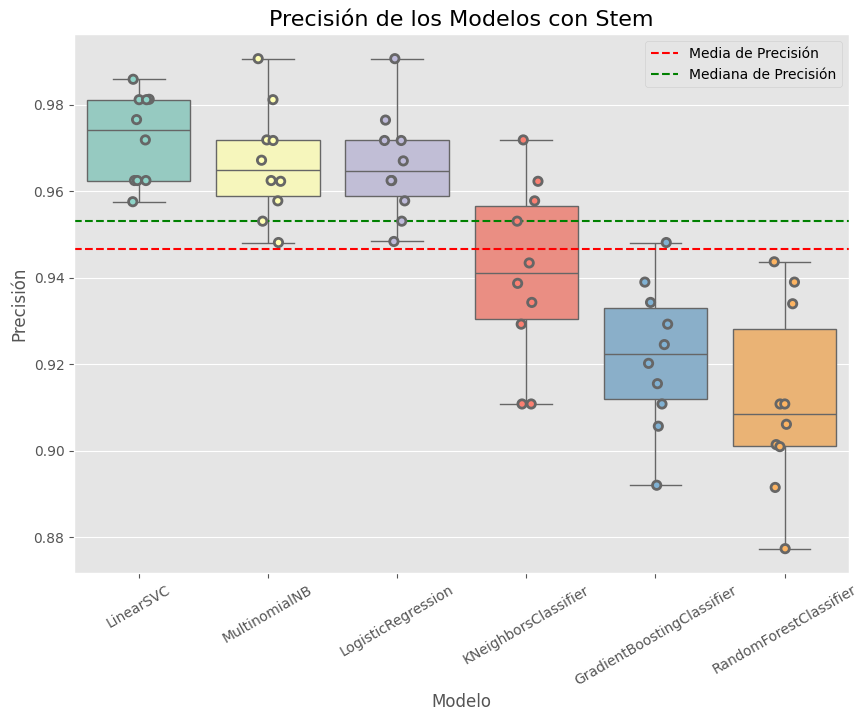

In [27]:
# Establecer tamaño de la figura Grafiacas de modelo con las palabras llevadas a su raiz.
figsize=(10, 7)
plt.rcParams['figure.figsize'] = figsize

# Gráfico de caja y bigotes con puntos superpuestos
sns.boxplot(x='model_name', y='accuracy', data=cv_df, order=cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False).index, palette="Set3")
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=6, jitter=True, edgecolor="gray", linewidth=2, order=cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False).index, palette="Set3")

# Etiquetas y título
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.title('Precisión de los Modelos con Stem', fontsize=16)

# Añadir líneas horizontales para la media y mediana
plt.axhline(y=cv_df['accuracy'].mean(), color='r', linestyle='--', label='Media de Precisión')
plt.axhline(y=cv_df['accuracy'].median(), color='g', linestyle='--', label='Mediana de Precisión')

# Mostrar leyenda
plt.legend()

# Rotar etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=30)

# Mostrar la gráfica
plt.show()

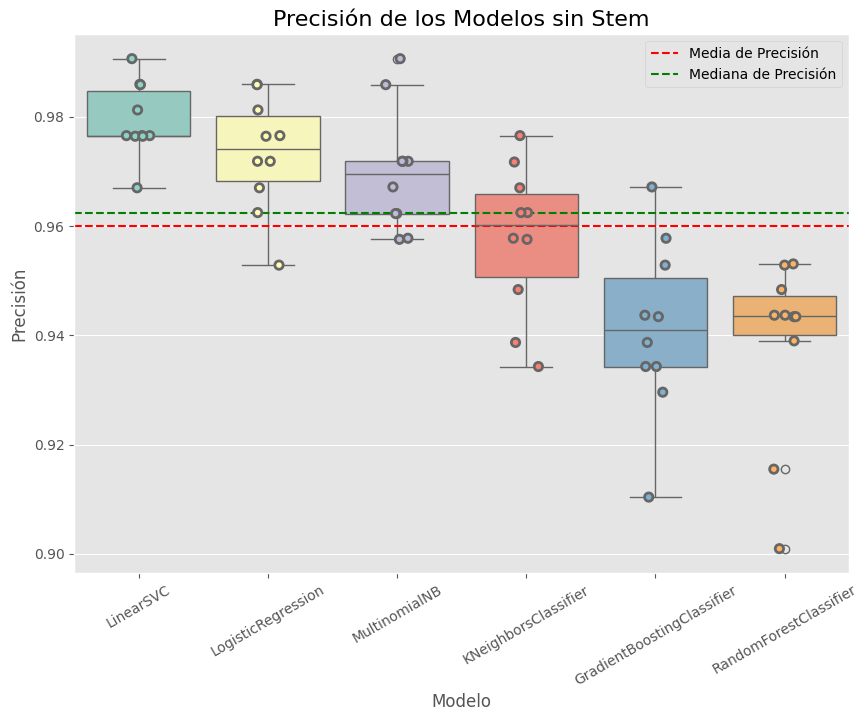

In [28]:
# Establecer tamaño de la figura
figsize=(10, 7)
plt.rcParams['figure.figsize'] = figsize

# Gráfico de caja y bigotes con puntos superpuestos
sns.boxplot(x='model_name', y='accuracy', data=cv_df_norm, order=cv_df_norm.groupby('model_name').accuracy.mean().sort_values(ascending=False).index, palette="Set3")
sns.stripplot(x='model_name', y='accuracy', data=cv_df_norm, size=6, jitter=True, edgecolor="gray", linewidth=2, order=cv_df_norm.groupby('model_name').accuracy.mean().sort_values(ascending=False).index, palette="Set3")

# Etiquetas y título
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.title('Precisión de los Modelos sin Stem', fontsize=16)

# Añadir líneas horizontales para la media y mediana
plt.axhline(y=cv_df_norm['accuracy'].mean(), color='r', linestyle='--', label='Media de Precisión')
plt.axhline(y=cv_df_norm['accuracy'].median(), color='g', linestyle='--', label='Mediana de Precisión')

# Mostrar leyenda
plt.legend()

# Rotar etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=30)

# Mostrar la gráfica
plt.show()

### 8. Creación del modelos finales
-  En esta parte entrenamos los dos mejores modelos obtenidos en la evaluación y se entrenan con el 80% de los datos y se prueban con el 20% restante.

In [29]:
# Mejores modelos identificados
model01 = LinearSVC()
model02 = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features_stem, labels_stem, df_stem.index, test_size=0.2, random_state=0)
model01.fit(X_train, y_train)
model02.fit(X_train, y_train)

LogisticRegression(random_state=0)

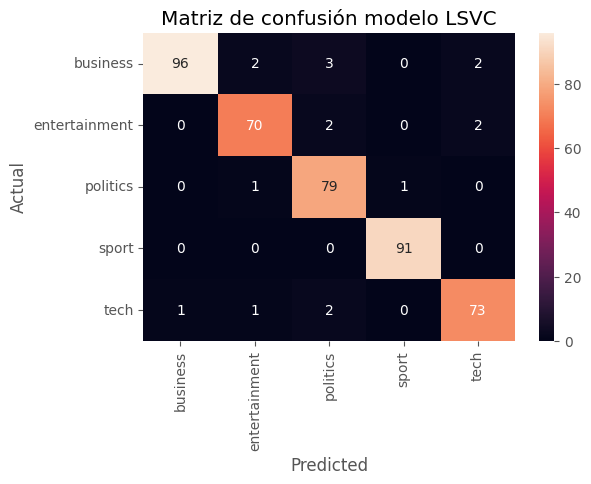

               precision    recall  f1-score   support

     business       0.99      0.93      0.96       103
entertainment       0.95      0.95      0.95        74
     politics       0.92      0.98      0.95        81
        sport       0.99      1.00      0.99        91
         tech       0.95      0.95      0.95        77

     accuracy                           0.96       426
    macro avg       0.96      0.96      0.96       426
 weighted avg       0.96      0.96      0.96       426



In [30]:
#Matriz de confusión primer modelo.
y_pred = model01.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=df['category'].sort_values().unique()
            , yticklabels=df['category'].sort_values().unique()
           )
plt.title('Matriz de confusión modelo LSVC')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_pred))

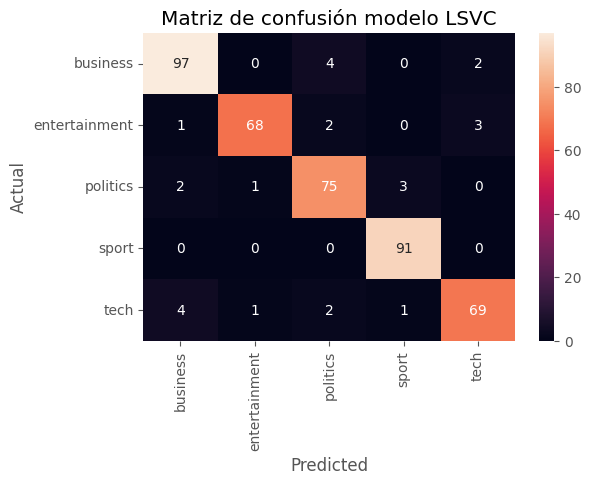

               precision    recall  f1-score   support

     business       0.93      0.94      0.94       103
entertainment       0.97      0.92      0.94        74
     politics       0.90      0.93      0.91        81
        sport       0.96      1.00      0.98        91
         tech       0.93      0.90      0.91        77

     accuracy                           0.94       426
    macro avg       0.94      0.94      0.94       426
 weighted avg       0.94      0.94      0.94       426



In [31]:
#Matriz de confusión segundo modelo.
y_pred = model02.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=df['category'].sort_values().unique()
            , yticklabels=df['category'].sort_values().unique()
           )
plt.title('Matriz de confusión modelo LSVC')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred))

In [32]:
#Se guarda el modelo de LSVC
joblib.dump(model01, '/gdrive/MyDrive/ML/model01.model')

['/gdrive/MyDrive/ML/model01.model']

In [33]:
#Se guarda el modelo de Regresión logística
joblib.dump(model02, '/gdrive/MyDrive/ML/model02.model')

['/gdrive/MyDrive/ML/model02.model']

### 9. Producción
- Se realizan varias pruebas con nuevas noticias con los modelos guardados.
- Para las pruebas se realiza un procesado inicial del texto de las nuevas noticias para normalizar y llevar el texto a la raiz.

In [34]:
model01C = joblib.load('/gdrive/MyDrive/ML/model01.model') # Carga del modelo.
model02C =  joblib.load('/gdrive/MyDrive/ML/model02.model') # Carga del modelo.

In [35]:
def normalize(text):
  doc = nlp(text)  # Tokenizar el texto utilizando Spacy
  words = [t.orth_ for t in doc if not t.is_punct | t.is_stop]
  lexical_tokens = [t.lower() for t in words if len(t) > 3 and t.isalpha()]
  return lexical_tokens  # Retornar lista de palabras filtradas

def queryCategory(query):
    """
    Esta función toma una consulta como entrada y devuelve una predicción de la categoría a la que pertenece esa consulta.

    Args:
        query (str): La consulta de entrada que se quiere categorizar.

    Returns:
        list: Una lista de predicciones de categoría para la consulta dada. Si no se encuentra ninguna coincidencia, devuelve una lista vacía.
    """
    # Normalizar el texto de la consulta
    text_norm = normalize(query)

    # Llevar cada palabra del texto a su raíz utilizando el stemmer de Snowball
    stems = [snow_stemmer.stem(token) for token in text_norm]

    # Unir las palabras raíz en un solo texto
    text_stem = " ".join(stems)

    # Convertir el texto raíz en características vectoriales usando el vectorizador 'vectorizer_stem'
    texts = [text_stem]
    text_features = vectorizer_stem.transform(texts)

    # Obtener índices no cero de las características vectoriales
    p = text_features.nonzero()[0]

    # Si no hay características vectoriales no cero, devolver una lista vacía como predicción
    if p.size == 0:
        predictions =  []
    else:
        # Realizar predicciones de categoría utilizando modelos de clasificación ('model01C' y 'model02C')
        predictionsId = model01C.predict(text_features)
        predictionsId = np.append(predictionsId, model02C.predict(text_features))
        predictions = [predictionsId]

    return predictions

In [36]:
# Predicción de una noticia de entretenimiento
queryCategory("Renowned director John Smith has been tapped to helm the highly anticipated film adaptation of the best-selling novel -The Nightingale-. The novel, written by acclaimed author Jane Doe, has captivated readers worldwide with its gripping story of love, sacrifice, and resilience set against the backdrop of World War II. Smith, known for his masterful storytelling and visually stunning cinematography, is expected to bring the beloved characters and rich narrative of the novel to life on the big screen. With a talented cast and crew assembled, anticipation is high for this cinematic adaptation, which promises to be a poignant and unforgettable cinematic experience for audiences everywhere")

[array(['entertainment', 'entertainment'], dtype=object)]

In [37]:
# Predicción de una noticia de deportes
queryCategory("The International Olympic Committee (IOC) has unveiled updated guidelines for transgender athletes participating in Olympic events. Under the new regulations, transgender athletes will be eligible to compete in their affirmed gender category without undergoing surgery. Instead, they must demonstrate that their testosterone levels have been below a certain threshold for at least 12 months before their first competition. The decision comes after extensive consultation with medical experts and advocacy groups to ensure fairness and inclusion in Olympic sports. While some have welcomed the move as a step towards greater inclusivity, others have raised concerns about its potential impact on competitive fairness")

[array(['sport', 'sport'], dtype=object)]

In [38]:
# Predicción de una noticia de Economia
queryCategory("The central bank has decided to raise interest rates in an effort to curb inflationary pressures and stabilize the economy. The decision comes amid growing concerns about rising prices and overheating in certain sectors. By increasing borrowing costs, the central bank aims to reduce consumer spending and investment, which could help cool down inflationary pressures. However, the move is not without risks, as higher interest rates could also dampen economic growth and increase the burden on borrowers. The central bank has signaled its willingness to take further action if necessary to ensure price stability and sustainable economic growth")

[array(['business', 'business'], dtype=object)]

In [39]:
# Predicción de una noticia de tecnologia
queryCategory("A major tech company has announced plans to build a sustainable data center powered entirely by renewable energy sources. The facility, which will be located in a rural area, aims to minimize its environmental impact while maximizing energy efficiency. By harnessing wind, solar, and hydroelectric power, the company plans to achieve carbon neutrality for its data operations. This initiative reflects a growing trend among tech companies to prioritize sustainability and reduce their carbon footprint.")

[array(['business', 'business'], dtype=object)]

In [41]:
# Predicción de una noticia de politica
queryCategory("In response to mounting concerns over climate change, the government has introduced sweeping legislation aimed at combating environmental degradation and reducing greenhouse gas emissions. The proposed bill includes measures to promote renewable energy adoption, invest in green infrastructure projects, and implement stricter regulations on carbon emissions across various industries. Additionally, the legislation outlines targets for transitioning to clean energy sources and achieving carbon neutrality by a specified deadline. Environmental activists have praised the government's initiative as a crucial step towards mitigating the effects of climate change and preserving the planet for future generations. However, some critics have raised questions about the feasibility and economic implications of the proposed measures, highlighting the need for further debate and analysis before the legislation is enacted.")

[array(['politics', 'politics'], dtype=object)]

## Conclusiones y trabajo futuro
- Trabajar con textos demanda recursos de máquina importantes que se deben considerar e idealmente aplicar técnicas de procesamiento de texto para minimizar los mismos.
- Se obtuvieron muy buenos resultados con los modelos de maquinas de vectores de soporte lineal y regresión logistica incluso en noticias nuevas y se observa que hay una buena generalización con el modelo.
- Como trabajo futuro para evaluación de precisión del modelo sería interesante revisar cuales son las metricas de desempeño al probar este con un conjunto de noticias totalmente nuevas ya clasificadas para confirmar su uso.
- Adicional a lo anterior seria interesante revisar más a fondo la creación de la bolsa de palabras y ver si necesariamente se debe seguir trabajando con las caracteristicas extraidas o se puede realizar una reducción de estas variables de entrada.